In [8]:
import argparse

from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import mlflow
import mlflow.sklearn

In [9]:
TARGET_COL = "cost"

NUMERIC_COLS = [
    "distance",
    "dropoff_latitude",
    "dropoff_longitude",
    "passengers",
    "pickup_latitude",
    "pickup_longitude",
    "pickup_weekday",
    "pickup_month",
    "pickup_monthday",
    "pickup_hour",
    "pickup_minute",
    "pickup_second",
    "dropoff_weekday",
    "dropoff_month",
    "dropoff_monthday",
    "dropoff_hour",
    "dropoff_minute",
    "dropoff_second",
]

CAT_NOM_COLS = [
    "store_forward",
    "vendor",
]

CAT_ORD_COLS = [
]


In [10]:
# Set Variables

train_data = "../../../data",
model_output = "/tmp/train",
regressor__n_estimators = 500,
regressor__bootstrap = 1,
regressor__max_depth = 10,
regressor__max_features = "auto", 
regressor__min_samples_leaf = 4,
regressor__min_samples_split = 5

In [11]:
# Or set variables in class MyArgs

class MyArgs:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

args = MyArgs(
    train_data = "../../../data",
    model_output = "/tmp/train",
    regressor__n_estimators = 500,
    regressor__bootstrap = 1,
    regressor__max_depth = 10,
    regressor__max_features = "auto", 
    regressor__min_samples_leaf = 4,
    regressor__min_samples_split = 5)

In [12]:
os.makedirs(args.model_output, exist_ok = True)

In [20]:

def main(args):
    '''Read train dataset, train model, save trained model'''

    # Read train data
    train_data = pd.read_csv((Path(args.train_data) / 'taxi-data.csv'))

    # Split the data into input(X) and output(y)
    y_train = train_data[TARGET_COL]
    X_train = train_data[NUMERIC_COLS + CAT_NOM_COLS + CAT_ORD_COLS]

    # Train a Random Forest Regression Model with the training set
    model = RandomForestRegressor(n_estimators = args.regressor__n_estimators,
                                  bootstrap = args.regressor__bootstrap,
                                  max_depth = args.regressor__max_depth,
                                  max_features = args.regressor__max_features,
                                  min_samples_leaf = args.regressor__min_samples_leaf,
                                  min_samples_split = args.regressor__min_samples_split,
                                  random_state=0)

    # log model hyperparameters
    mlflow.log_param("model", "RandomForestRegressor")
    mlflow.log_param("n_estimators", args.regressor__n_estimators)
    mlflow.log_param("bootstrap", args.regressor__bootstrap)
    mlflow.log_param("max_depth", args.regressor__max_depth)
    mlflow.log_param("max_features", args.regressor__max_features)
    mlflow.log_param("min_samples_leaf", args.regressor__min_samples_leaf)
    mlflow.log_param("min_samples_split", args.regressor__min_samples_split)

    # Train model with the train set
    model.fit(X_train, y_train)

    # Predict using the Regression Model
    yhat_train = model.predict(X_train)

    # Evaluate Regression performance with the train set
    r2 = r2_score(y_train, yhat_train)
    mse = mean_squared_error(y_train, yhat_train)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_train, yhat_train)
    
    # log model performance metrics
    mlflow.log_metric("train r2", r2)
    mlflow.log_metric("train mse", mse)
    mlflow.log_metric("train rmse", rmse)
    mlflow.log_metric("train mae", mae)

    # Visualize results
    plt.scatter(y_train, yhat_train,  color='black')
    plt.plot(y_train, y_train, color='blue', linewidth=3)
    plt.xlabel("Real value")
    plt.ylabel("Predicted value")
    plt.savefig("regression_results.png")
    mlflow.log_artifact("regression_results.png")

    # Log the model
    mlflow.sklearn.log_model(sk_model=model, artifact_path=args.model_output)


In [21]:
mlflow.end_run()

Train dataset input path: ../../../data
Model output path: /tmp/train
n_estimators: 500
bootstrap: 1
max_depth: 10
max_features: auto
min_samples_leaf: 4
min_samples_split: 5


/anaconda/envs/sklearn-custom/lib/python3.7/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2022/10/10 17:38:29 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under azureml://experiments/Default/runs/ead0b1b7-8414-4faa-8394-29c94d115898/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the tracking store. If logging to a mlflow server via REST, consider upgrading the server version to MLflow 1.7.0 or above.


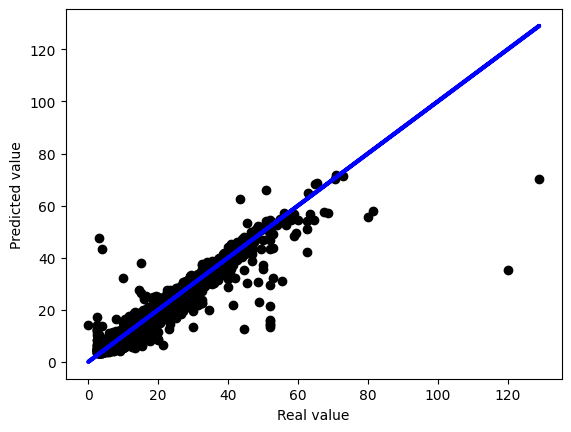

In [22]:
mlflow.start_run()

lines = [
    f"Train dataset input path: {args.train_data}",
    f"Model output path: {args.model_output}",
    f"n_estimators: {args.regressor__n_estimators}",
    f"bootstrap: {args.regressor__bootstrap}",
    f"max_depth: {args.regressor__max_depth}",
    f"max_features: {args.regressor__max_features}",
    f"min_samples_leaf: {args.regressor__min_samples_leaf}",
    f"min_samples_split: {args.regressor__min_samples_split}"
]

for line in lines:
    print(line)

main(args)

mlflow.end_run()

In [23]:
ls "/tmp/train" 